# CS339N Final Project - Head Motion as a Disease Biomarker

## Overview

This project explores the use of head motion, specifically framewise displacement, as a potential biomarker for disease. We focus on analyzing the framewise displacement derived from rsfMRI data to extract meaningful insights about patient movement during scans.

## fMRI Preprocessing

The raw fMRI BOLD signals undergo several preprocessing steps to ensure the data is clean and suitable for analysis. The major preprocessing steps include:
* Motion Correction: Aligns the fMRI images to correct for head movement during the scan.
* Slice Timing Correction: Adjusts for differences in acquisition time between slices.
* Spatial Normalization: Transforms the images to a standard space to allow for group analysis.
* Smoothing: Applies a Gaussian filter to reduce noise and improve signal-to-noise ratio.
* Confound Regression: Removes unwanted variability from the data, such as physiological noise and motion artifacts.
 
One of the key outputs of this preprocessing is the generation of timeseries "confounds," which include various metrics that describe the quality and characteristics of the fMRI data. Among these confounds is framewise displacement, a measure of head motion between consecutive frames.

## Data Layout

Here, I have extracted the framewise displacement data along with the metadata of each patient. This data is stored in the `framewise_displacement_data.npz` file. The extracted data is first loaded and converted into a dictionary format. This dictionary, `framewise_displacement_data`, is structured as follows:
* Keys: Each key is a combination of the subject ID and run ID, formatted as sub-<subject_id>_run-<run_id>.
* Values: Each value is a dictionary containing:
    * framewise_displacement: A list of framewise displacement values for the corresponding run. I believe the first element of each one is NaN--will fix this later and resave the file, though dropping the first element is a simple temporary fix.
    * dvars: spatial framewise standard deviation
    * rsmd: root mean square displacement between successive images
    * participant_info: A dictionary with metadata about the participant, including group, sex, and age.
 
## Relevant Prior Work

1. https://link.springer.com/article/10.1007/s10548-014-0358-6. Closest but older and small sample size with no biomarkers and averaged parameters
2. https://www.sciencedirect.com/science/article/pii/S2666956022000095#bib4
3. https://www.sciencedirect.com/science/article/pii/S1053811919310249
4. https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.70143. Only large-scale attempt, but again the analyses are quite limited

PD: Removed 283 out of 603
Control: Removed 38 out of 82


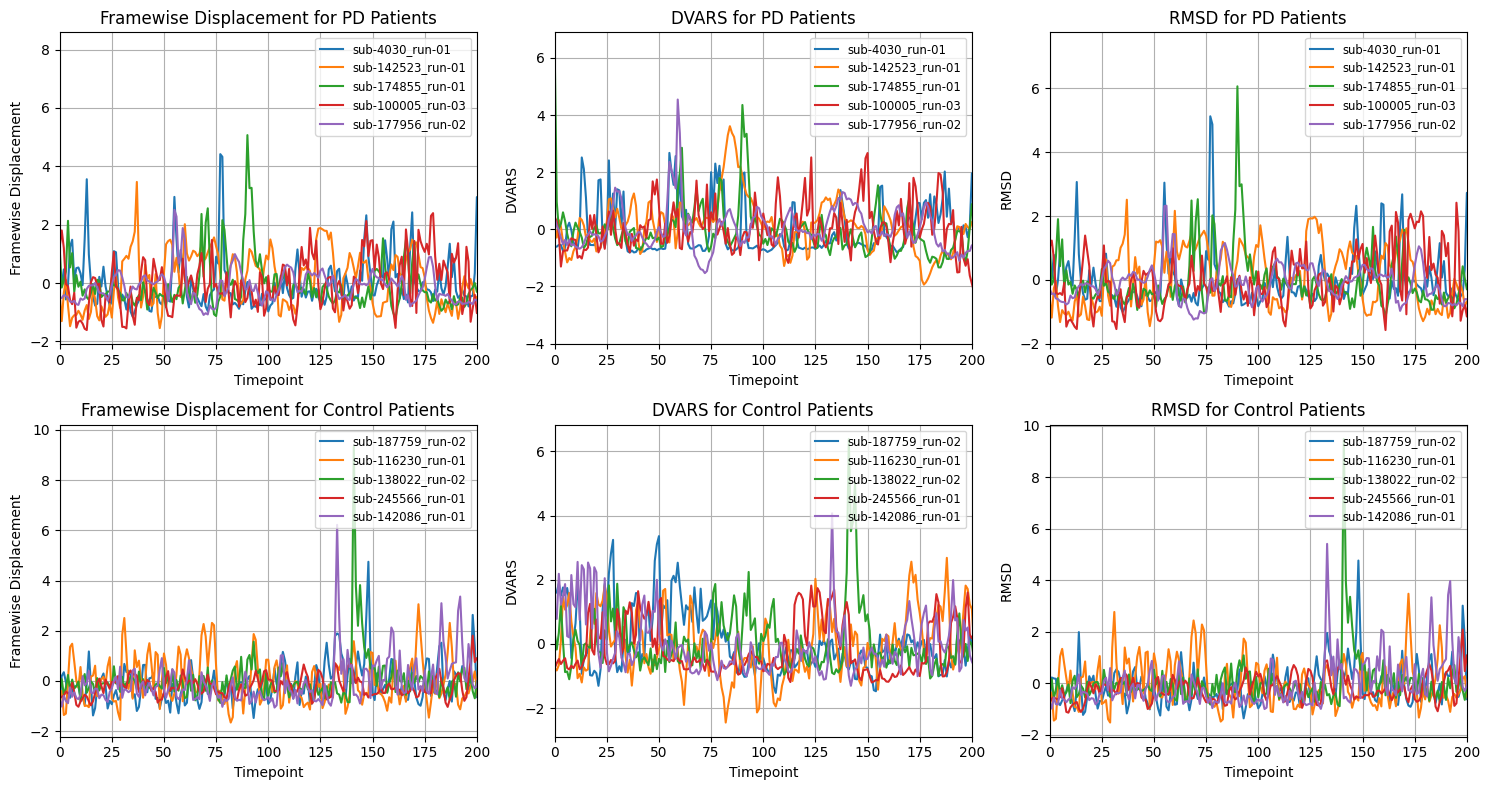

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load the data from the .npz file
data_file = 'framewise_displacement_data.npz'
data = np.load(data_file, allow_pickle=True)

# Convert the loaded data to a dictionary
framewise_displacement_data = {key: data[key].item() for key in data}

# # Filter keys for PD and control patients with at least 50 timesteps
# pd_keys = [key for key, value in framewise_displacement_data.items() 
#            if value['participant_info'].get('group') == 'PD' and len(value['framewise_displacement']) >= 100]
# control_keys = [key for key, value in framewise_displacement_data.items() 
#                 if value['participant_info'].get('group') == 'Control' and len(value['framewise_displacement']) >= 100]

# Filter and print removal counts for PD and Control groups
def filter_valid_subjects(data_dict, group_name):
    valid_keys = []
    removed_count = 0

    for key, value in data_dict.items():
        if value['participant_info'].get('group') != group_name:
            continue
        if len(value['framewise_displacement']) < 100 or len(value['dvars']) < 2:
            removed_count += 1
            continue
        if np.std(value['dvars']) <= 1e-6:
            removed_count += 1
            continue
        valid_keys.append(key)

    print(f"{group_name}: Removed {removed_count} out of {len([v for v in data_dict.values() if v['participant_info'].get('group') == group_name])}")
    return valid_keys

pd_keys = filter_valid_subjects(framewise_displacement_data, 'PD')
control_keys = filter_valid_subjects(framewise_displacement_data, 'Control')

# Plot examples
def plot_metrics(pd_keys, control_keys, num_examples=5):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    metrics = ['framewise_displacement', 'dvars', 'rmsd']
    titles = ['Framewise Displacement', 'DVARS', 'RMSD']
    
    for i, metric in enumerate(metrics):
        # Plot for PD patients
        for key in pd_keys[:num_examples]:
            z = framewise_displacement_data[key][metric][1:]
            z = (z - np.mean(z)) / np.std(z)
            smoothed = gaussian_filter1d(z, sigma=0.5)
            axes[0, i].plot(smoothed, label=f'{key}')
            # axes[0, i].plot(framewise_displacement_data[key][metric], label=f'{key}')
        axes[0, i].set_title(f'{titles[i]} for PD Patients')
        axes[0, i].set_xlabel('Timepoint')
        axes[0, i].set_ylabel(titles[i])
        axes[0, i].set_xlim(0, 200)
        axes[0, i].grid(True)
        
        # Plot for Control patients
        for key in control_keys[:num_examples]:
            z = framewise_displacement_data[key][metric][1:]
            z = (z - np.mean(z)) / np.std(z)
            smoothed = gaussian_filter1d(z, sigma=0.5)
            axes[1, i].plot(smoothed, label=f'{key}')
            # axes[1, i].plot(framewise_displacement_data[key][metric], label=f'{key}')
        axes[1, i].set_title(f'{titles[i]} for Control Patients')
        axes[1, i].set_xlabel('Timepoint')
        axes[1, i].set_ylabel(titles[i])
        axes[1, i].set_xlim(0, 200)
        axes[1, i].grid(True)
    
    # Add legends
    for ax in axes.flatten():
        ax.legend(loc='upper right', fontsize='small')

    # axes[0, 1].set_ylim(0, 150)
    # axes[1, 1].set_ylim(0, 150)
    
    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(pd_keys, control_keys)

In [90]:
"""
Train simple sequence models (GRU, LSTM, Transformer) to classify
Parkinson's disease (PD) vs Control from motion-derived rs-fMRI metrics.

Usage
-----
python pd_motion_classification.py --data framewise_displacement_data.npz
"""

import argparse
import random
from pathlib import Path

import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

# ----------------------- Hyper-parameters ----------------------- #
MAX_LEN = 100  # truncate / zero-pad sequences to this length
BATCH_SIZE = 32
EPOCHS = 100
LR = 2e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG_SEED = 42

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

# ----------------------- Data utilities ------------------------ #

def filter_valid_subjects(data_dict, group_name):
    """Return keys of subjects in *group_name* with sane signal lengths/variance."""
    ok = []
    for k, v in data_dict.items():
        if v["participant_info"].get("group") != group_name:
            continue
        if len(v["framewise_displacement"]) < 100 or len(v["dvars"]) < 2:
            continue
        if np.std(v["dvars"]) <= 1e-6:
            continue
        ok.append(k)
    return ok


class MotionDataset(Dataset):
    """Dataset returning (T, 3) float32 tensor + binary label."""

    def __init__(self, data_dict, keys):
        self.samples = []
        for k in keys:
            rec = data_dict[k]
            fd, dv, rmsd = (
                np.array(rec[m][1:]) for m in ("framewise_displacement", "dvars", "rmsd")
            )

            def z(x):
                return (x - x.mean()) / (x.std() + 1e-6)

            seq = np.stack([z(fd[:MAX_LEN]), z(dv[:MAX_LEN]), z(rmsd[:MAX_LEN])], axis=1)
            # pad with zeros if shorter than MAX_LEN
            if seq.shape[0] < MAX_LEN:
                pad = np.zeros((MAX_LEN - seq.shape[0], 3), dtype=np.float32)
                seq = np.vstack([seq, pad])
            label = 1 if rec["participant_info"].get("group") == "PD" else 0
            self.samples.append((seq.astype(np.float32), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.float32)


# ----------------------- Model definitions --------------------- #

def _last_hidden(h):
    """Handle LSTM (h, c) tuple vs GRU tensor, return last layer hidden."""
    if isinstance(h, tuple):
        h = h[0]
    return h[-1]


class RNNClassifier(nn.Module):
    def __init__(self, cell="gru", hidden_dim=64, num_layers=1):
        super().__init__()
        cell_cls = {"gru": nn.GRU, "lstm": nn.LSTM, "rnn": nn.RNN}[cell]
        self.rnn = cell_cls(
            input_size=3, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, h = self.rnn(x)
        out = self.fc(_last_hidden(h))
        return out.squeeze(-1)


class TransformerClassifier(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.proj = nn.Linear(3, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.proj(x)
        x = self.encoder(x)
        pooled = x.mean(dim=1)
        return self.fc(pooled).squeeze(-1)


# ----------------------- Train / eval helpers ------------------ #

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    probs, targets = [], []
    for seq, lbl in loader:
        seq = seq.to(DEVICE)
        logits = model(seq)
        probs.extend(torch.sigmoid(logits).cpu().numpy().ravel())
        targets.extend(lbl.numpy())
    preds = (np.array(probs) > 0.5).astype(int)
    acc = accuracy_score(targets, preds)
    bal_acc = balanced_accuracy_score(targets, preds)
    try:
        auc = roc_auc_score(targets, probs)
    except ValueError:
        auc = float("nan")
    return acc, bal_acc, auc, preds, targets


@torch.no_grad()
def get_predictions(model, loader):
    """Return hard preds and ground-truth labels for *loader*."""
    _, _, _, preds, targets = evaluate(model, loader)
    return preds, targets



def train(model, train_loader, val_loader):
    model.to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    crit = nn.BCEWithLogitsLoss()
    for ep in range(1, EPOCHS + 1):
        model.train()
        for seq, lbl in train_loader:
            seq, lbl = seq.to(DEVICE), lbl.to(DEVICE)
            loss = crit(model(seq), lbl)
            optim.zero_grad()
            loss.backward()
            optim.step()
        if ep % 5 == 0 or ep == EPOCHS:
            acc, bal_acc, auc, _, _ = evaluate(model, val_loader)
            print(
                f"Epoch {ep:02d}/{EPOCHS}  val_acc={acc:.3f}  val_bal_acc={bal_acc:.3f}  val_auc={auc:.3f}"
            )


# ----------------------- Main script --------------------------- #

def main(path_npz: Path):
    data = np.load(path_npz, allow_pickle=True)
    data_dict = {k: data[k].item() for k in data}

    keys = filter_valid_subjects(data_dict, "PD") + filter_valid_subjects(
        data_dict, "Control"
    )
    random.shuffle(keys)

    dataset = MotionDataset(data_dict, keys)
    val_len = int(0.2 * len(dataset))
    train_len = len(dataset) - val_len
    train_set, val_set = random_split(
        dataset, [train_len, val_len], generator=torch.Generator().manual_seed(RNG_SEED)
    )

    # class-balanced sampler for the train split
    train_labels = [dataset.samples[i][1] for i in train_set.indices]
    class_counts = np.bincount(train_labels)
    weights = 1.0 / class_counts
    sample_wts = [weights[lbl] for lbl in train_labels]
    sampler = WeightedRandomSampler(
        sample_wts, num_samples=len(sample_wts), replacement=True
    )

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

    models = {
        "GRU": RNNClassifier(cell="gru"),
        "LSTM": RNNClassifier(cell="lstm"),
        "Transformer": TransformerClassifier(),
    }

    for name, model in models.items():
        print(f"\nTraining {name}…")
        train(model, train_loader, val_loader)
        acc, bal_acc, auc, _, _ = evaluate(model, val_loader)
        print(
            f"{name} final  ACC={acc:.3f}  BAL_ACC={bal_acc:.3f}  AUC={auc:.3f}"
        )

        preds, targets = get_predictions(model, val_loader)
        cm = confusion_matrix(targets, preds)
        print("Confusion matrix:\n", cm)
        print(classification_report(targets, preds, digits=3))


main("framewise_displacement_data.npz")


Training GRU…
Epoch 05/100  val_acc=0.556  val_bal_acc=0.641  val_auc=0.721
Epoch 10/100  val_acc=0.778  val_bal_acc=0.602  val_auc=0.686
Epoch 15/100  val_acc=0.708  val_bal_acc=0.508  val_auc=0.555
Epoch 20/100  val_acc=0.583  val_bal_acc=0.547  val_auc=0.527
Epoch 25/100  val_acc=0.778  val_bal_acc=0.602  val_auc=0.537
Epoch 30/100  val_acc=0.681  val_bal_acc=0.547  val_auc=0.564
Epoch 35/100  val_acc=0.722  val_bal_acc=0.461  val_auc=0.467
Epoch 40/100  val_acc=0.681  val_bal_acc=0.438  val_auc=0.436
Epoch 45/100  val_acc=0.736  val_bal_acc=0.469  val_auc=0.467
Epoch 50/100  val_acc=0.694  val_bal_acc=0.555  val_auc=0.574
Epoch 55/100  val_acc=0.722  val_bal_acc=0.570  val_auc=0.525
Epoch 60/100  val_acc=0.750  val_bal_acc=0.586  val_auc=0.504
Epoch 65/100  val_acc=0.708  val_bal_acc=0.508  val_auc=0.510
Epoch 70/100  val_acc=0.778  val_bal_acc=0.547  val_auc=0.559
Epoch 75/100  val_acc=0.778  val_bal_acc=0.547  val_auc=0.547
Epoch 80/100  val_acc=0.764  val_bal_acc=0.484  val_auc

In [69]:
np.std(framewise_displacement_data['sub-100005_run-03']['dvars'])

0.04678757903496713

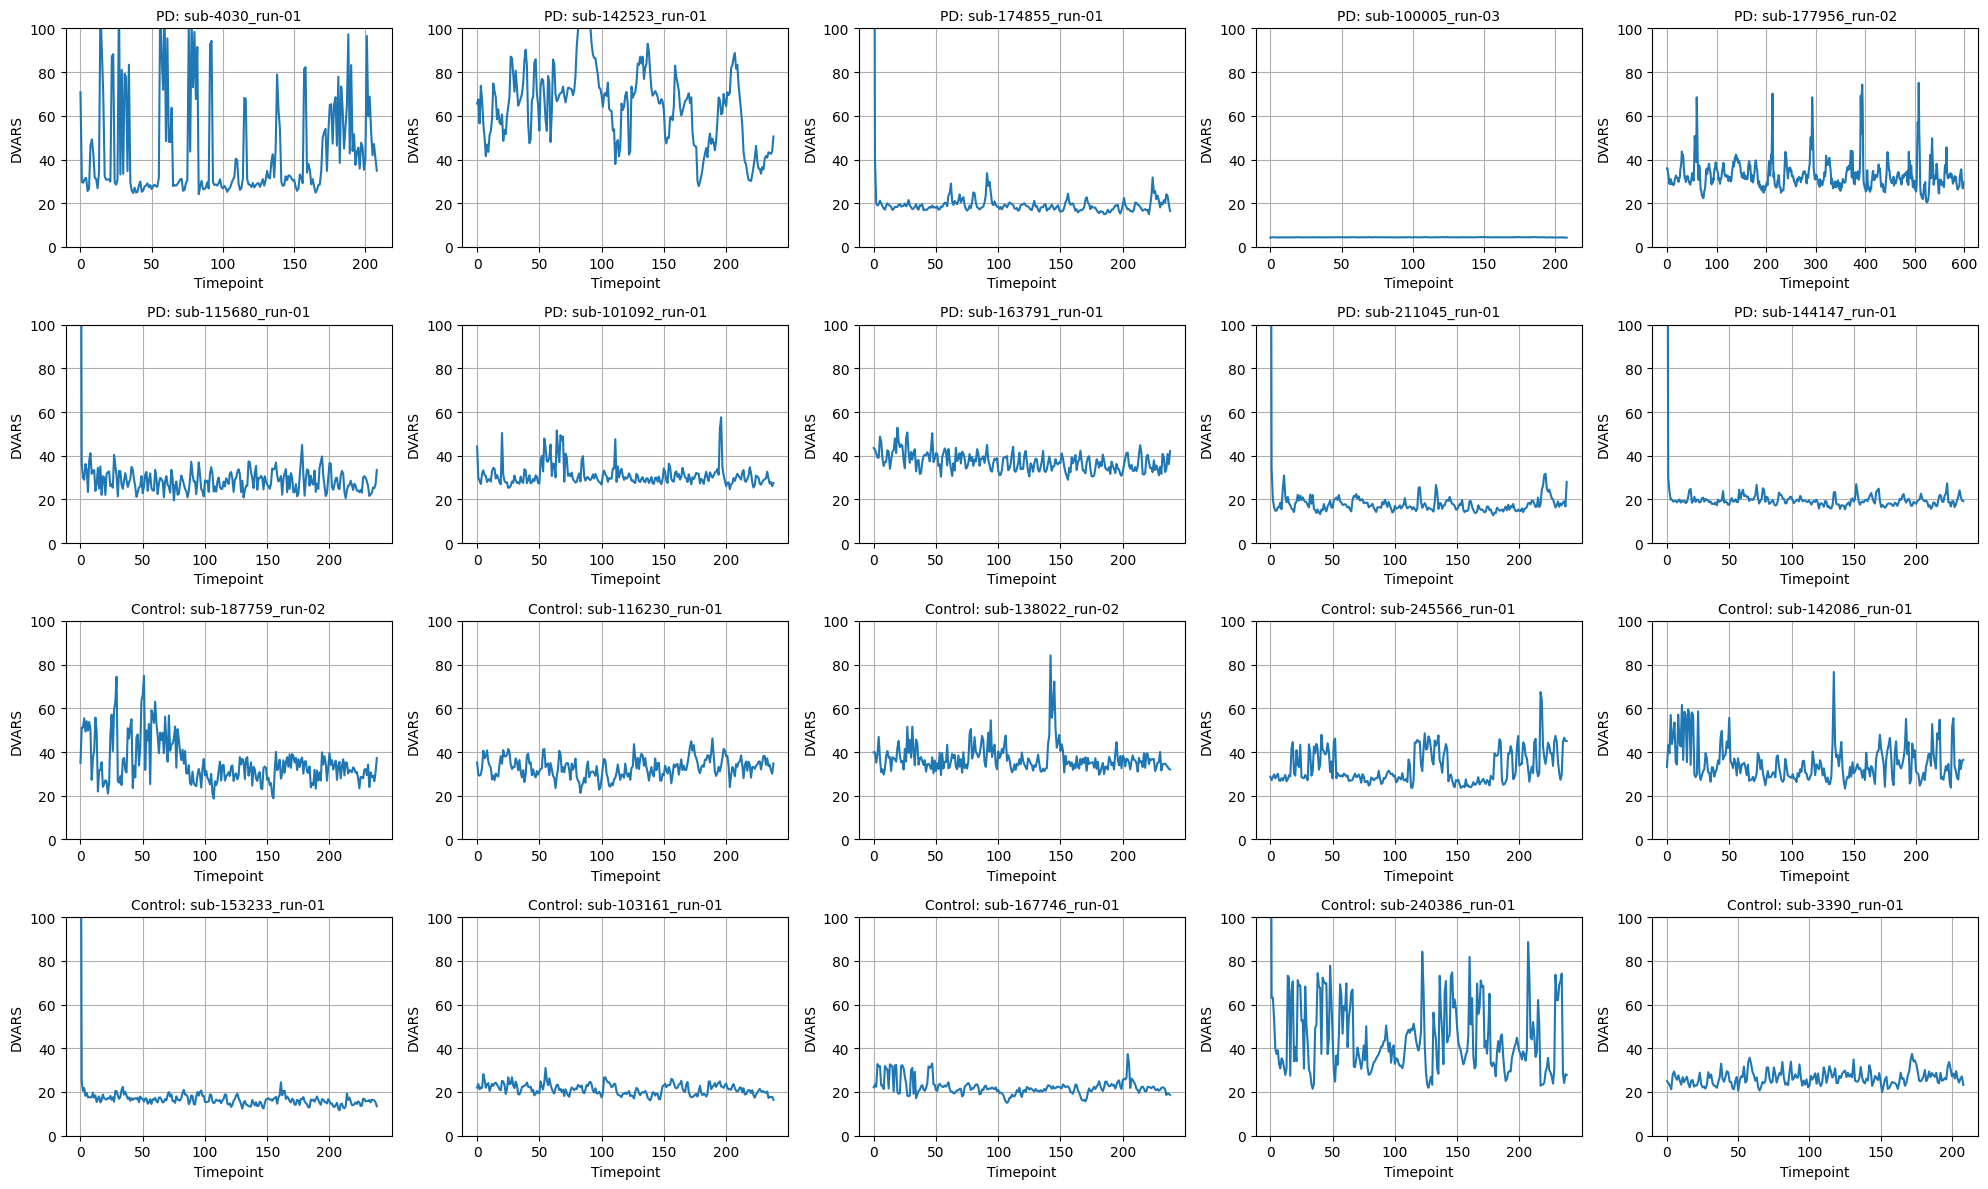

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data_file = 'framewise_displacement_data.npz'
data = np.load(data_file, allow_pickle=True)
framewise_displacement_data = {key: data[key].item() for key in data}

# Filter keys
pd_keys = [key for key, value in framewise_displacement_data.items()
           if value['participant_info'].get('group') == 'PD' and len(value['framewise_displacement']) >= 50]
control_keys = [key for key, value in framewise_displacement_data.items()
                if value['participant_info'].get('group') == 'Control' and len(value['framewise_displacement']) >= 50]

# Plot each subject in a separate subplot
def plot_individual_subplots(pd_keys, control_keys, metric='dvars', num_examples=10):
    total = num_examples * 2
    cols = 5
    rows = (total + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    all_keys = [(key, 'PD') for key in pd_keys[:num_examples]] + [(key, 'Control') for key in control_keys[:num_examples]]

    for i, (key, group) in enumerate(all_keys):
        ax = axes[i]
        ax.plot(framewise_displacement_data[key][metric])
        ax.set_title(f'{group}: {key}', fontsize=10)
        ax.set_ylim(0, 100)
        ax.set_xlabel('Timepoint')
        ax.set_ylabel(metric.upper())
        ax.grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Run the plot
plot_individual_subplots(pd_keys, control_keys, metric='dvars')

PD: Removed 283 out of 603
Control: Removed 38 out of 82


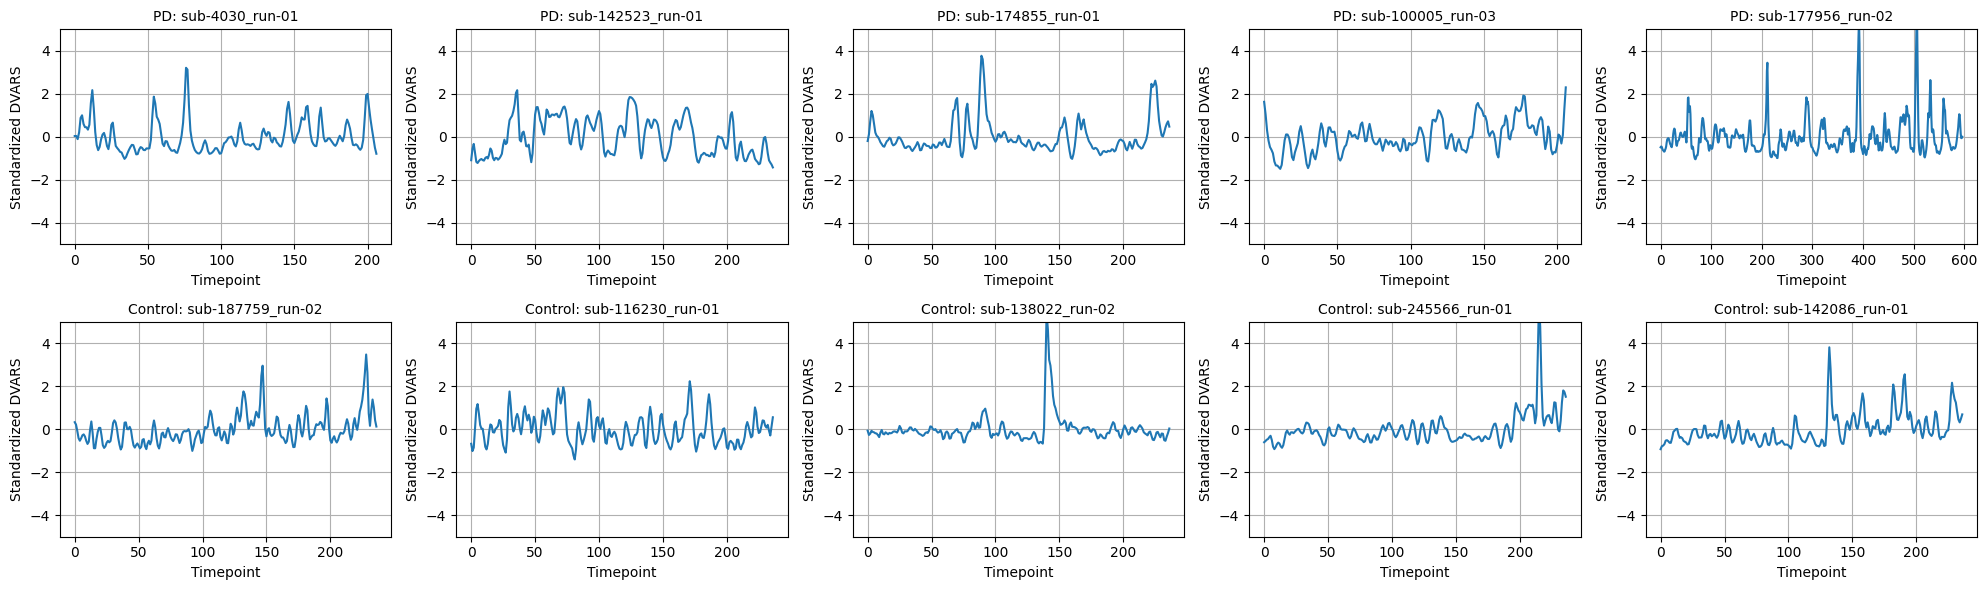

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load data
data_file = 'framewise_displacement_data.npz'
data = np.load(data_file, allow_pickle=True)
framewise_displacement_data = {key: data[key].item() for key in data}

# Filter and print removal counts for PD and Control groups
def filter_valid_subjects(data_dict, group_name):
    valid_keys = []
    removed_count = 0

    for key, value in data_dict.items():
        if value['participant_info'].get('group') != group_name:
            continue
        if len(value['framewise_displacement']) < 100 or len(value['dvars']) < 2:
            removed_count += 1
            continue
        if np.max(value['dvars']) <= 1:
            removed_count += 1
            continue
        valid_keys.append(key)

    print(f"{group_name}: Removed {removed_count} out of {len([v for v in data_dict.values() if v['participant_info'].get('group') == group_name])}")
    return valid_keys

pd_keys = filter_valid_subjects(framewise_displacement_data, 'PD')
control_keys = filter_valid_subjects(framewise_displacement_data, 'Control')

# Plot standardized DVARS
def plot_standardized_dvars(pd_keys, control_keys, num_examples=5):
    total = num_examples * 2
    cols = 5
    rows = (total + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    all_keys = [(key, 'PD') for key in pd_keys[:num_examples]] + [(key, 'Control') for key in control_keys[:num_examples]]

    for i, (key, group) in enumerate(all_keys):
        ax = axes[i]
        dvars = framewise_displacement_data[key]['framewise_displacement'][1:]
        dvars_std = (dvars - np.mean(dvars)) / np.std(dvars)
        smoothed = gaussian_filter1d(dvars_std[1:], sigma=1.0)
        ax.plot(smoothed) # dvars_std
        
        ax.set_title(f'{group}: {key}', fontsize=10)
        ax.set_ylim(-5, 5)
        # ax.set_ylim(0, 100)
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Standardized DVARS')
        ax.grid(True)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_standardized_dvars(pd_keys, control_keys)

PD: Removed 0 / 320 low-signal samples.
Control: Removed 0 / 44 low-signal samples.


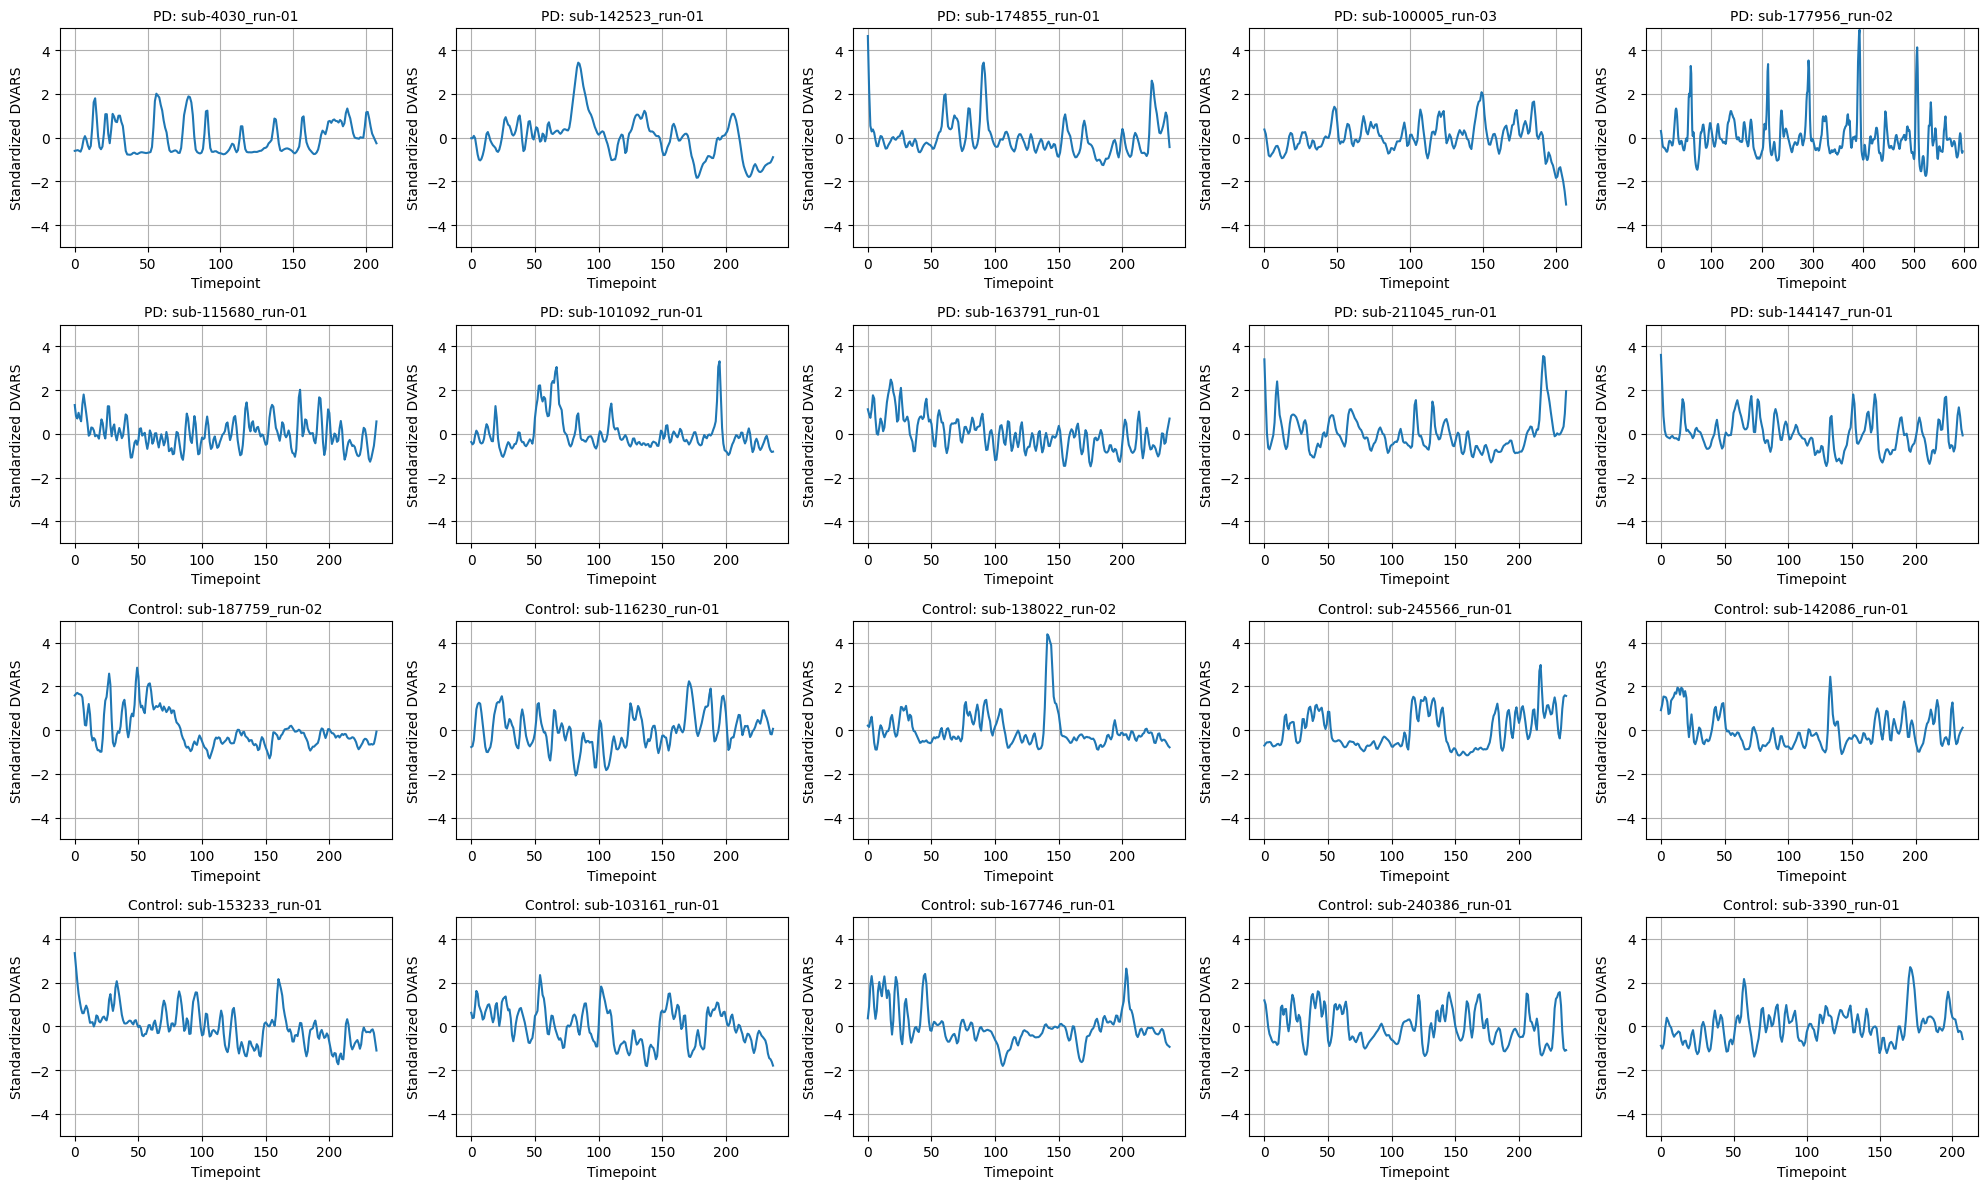

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load data
data_file = 'framewise_displacement_data.npz'
data = np.load(data_file, allow_pickle=True)
framewise_displacement_data = {key: data[key].item() for key in data}

# Filter keys for minimum length
min_timesteps = 100
pd_keys = [key for key, val in framewise_displacement_data.items()
           if val['participant_info'].get('group') == 'PD' and len(val['dvars']) >= min_timesteps]
control_keys = [key for key, val in framewise_displacement_data.items()
                if val['participant_info'].get('group') == 'Control' and len(val['dvars']) >= min_timesteps]

# Standardize and filter based on signal magnitude
def filter_keys(keys, cohort_name):
    kept = []
    removed = []
    for key in keys:
        dvars = framewise_displacement_data[key]['dvars'][1:]
        z = (dvars - np.mean(dvars)) / np.std(dvars)
        if np.max(np.abs(z)) < 0.5:
            removed.append(key)
        else:
            kept.append(key)
    print(f"{cohort_name}: Removed {len(removed)} / {len(keys)} low-signal samples.")
    return kept

pd_keys_filtered = filter_keys(pd_keys, 'PD')
control_keys_filtered = filter_keys(control_keys, 'Control')

# Plot standardized DVARS
def plot_standardized_dvars(pd_keys, control_keys, num_examples=10):
    total = num_examples * 2
    cols = 5
    rows = (total + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()

    all_keys = [(key, 'PD') for key in pd_keys[:num_examples]] + [(key, 'Control') for key in control_keys[:num_examples]]

    for i, (key, group) in enumerate(all_keys):
        ax = axes[i]
        dvars = framewise_displacement_data[key]['dvars'][1:]
        z = (dvars - np.mean(dvars)) / np.std(dvars)
        smoothed = gaussian_filter1d(z, sigma=1.0)
        ax.plot(smoothed)
        ax.set_title(f'{group}: {key}', fontsize=10)
        ax.set_ylim(-5, 5)
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Standardized DVARS')
        ax.grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot filtered examples
plot_standardized_dvars(pd_keys_filtered, control_keys_filtered)


## Example

In [30]:
print("Example Subject Framewise Displacement Shape:", len(framewise_displacement_data['sub-187759_run-02']['framewise_displacement']))

Example Subject Framewise Displacement Shape: 239
